In [1]:
%%capture
!pip install neuralforecast mlforecast statsforecast sktime sweetviz pmdarima xgboost

In [2]:
# Desativar as mensagens de 'warning' que ficam poluindo o output aqui no Colab

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Importações dos módulos necessários para autenticar na minha conta Google e acessar o Drive
import  pandas as pd, \
        numpy as np,  \
        requests as rt, \
        seaborn as sns, \
        datetime as dt, \
        matplotlib.pyplot as plt

from IPython.display import display, Markdown

from xgboost import XGBRegressor

from io               import BytesIO
from matplotlib       import style
from matplotlib.pylab import rcParams
from pandas.plotting  import register_matplotlib_converters

from neuralforecast         import NeuralForecast
from neuralforecast.models  import LSTM, NHITS
from neuralforecast.auto    import AutoLSTM, AutoNHITS
# from neuralforecast.utils   import AirPassengersDF

from sklearn.metrics         import r2_score, mean_squared_error
from sklearn.linear_model    import LinearRegression
from sklearn.preprocessing   import MinMaxScaler
from sklearn.ensemble        import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit

from sktime.utils.plotting import plot_series
# from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection     import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError, MeanAbsoluteScaledError

# Ajustes feitos para geração e criação de gráfico
style.use('ggplot')
rcParams['figure.figsize'] = 15, 6

# Tratar conversões de DateTime entre o Pandas e o Matplotlib
register_matplotlib_converters()

# Symmetric Mean Absolute Percentage Error
smape = MeanAbsolutePercentageError(symmetric=True)

# Mean Absolute Scaled Error -> essa métrica é scaled-free
mase = MeanAbsoluteScaledError()

In [4]:
def sliding_window(data, n_lags=1, n_targets=1, dropnan=True):
	"""
	Rearranja a série temporal como um dataset para aprendizado supervisionado.
	Argumentos:
		data: Sequência de observações. Pode ser list ou NumPy array
		n_lags: Número de lags das observações que serão usadas como input (X).
		n_targets: Número de observações que serão usadas como output (y).
		dropnan: Booleano pra dropar as linhas que ficarem com NaN .
	Retorna:
		Um DataFrame como uma série ajustada para aprendizado supervisionado.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]

	df = pd.DataFrame(data)
	cols, names = list(), list()

	# As lags (t-n, ... t-1)
	for i in range(n_lags, 0, -1):
		cols.append(df.shift(i))
		names += [('X_%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

	# Prever uma sequência (t, t+1, ... t+n)
	for i in range(0, n_targets):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('y_%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('y_%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

	# Junta tudo
	agg = pd.concat(cols, axis=1)
	agg.columns = names

	# Dropa as linhas com NaN
	if dropnan:
		agg.dropna(inplace=True)

	return agg # IMPORTANTE!!!! O retorno sai com as colunas com nome zuado. Tem que renomear o DataFrame resultante depois.

In [5]:
# O corte realizado por esse método é simples: pega do início da série até train_size e coloca num dataframe para treino
# O que resta do corte anterior, é colocado no dataframe para teste
def split_train_test(df, train_size=0.7):

  # Tamanho total da série
  size = df.shape[0]

  # Tamanho do treino
  t_size = int(size * train_size)

  train_data = df.iloc[0:t_size]
  validation_data = df.iloc[t_size:]

  return train_data, validation_data

# Carregando os dados de chuva e vazão da estação telemétrica

In [6]:
def read_telemetrica_chuva_vazao(codigoEstacao, tipoEstacao, chave):
  link = 'https://docs.google.com/spreadsheets/d/' + chave + '/export?format=xlsx'
  r = rt.get(link)
  data = r.content
  df = pd.read_excel(BytesIO(data), sheet_name='telemetrica_56994500', header=0, parse_dates=['data_hora'])

  # Ajustando a coluna correspondente à data para o tipo datetime e convertendo para o formato "Period" de frequência "15T" (a cada 15 minutos)
  # A biblioteca 'sktime' só consegue lidar com o campo 'Data' se estiver neste formato de dado
  # df['data_hora'] = pd.DatetimeIndex(df['data_hora']).to_period('15T')

  # A partir do objeto criado anteriormente, agora eu 'corto' entre TREINO e VALIDAÇÃO
  # Será 75% para TESTE e 25% para VALIDAÇÃO calculados à partir do início da série temporal
  # treino, validacao = temporal_train_test_split(df, train_size=0.75, anchor="start")
  # treino.name, validacao.name = 'Treino', 'Validação'

  # ForecastHorizon, o horizonte de tempo que pretende-se realizar a previsão.
  # Está em questão de meses porque os dados são mensais.
  # A ser utilizado com a biblioteca 'sktime'
  # fh = pd.PeriodIndex(data=validacao.index.values)

  # As colunas importantes para entrada no NeuralForecast/LSTM são mesmo "unique_id", "data_hora" e "vazao".
  # Contudo, se colocar mais coluna que conserva relação com o alvo ("vazao"), isso ajuda a aprimorar mais o resultado do modelo. => DICA IMPORTANTE
  # É com isso em mente que entra a coluna "chuva"
  feature_names = ['chuva', 'vazao']
  target_names = 'vazao'

  # O NeuralForecast/LSTM demanda uma coluna nomeada "unique_id"
  # A coluna serve como identificador ÚNICO da série temporal e pode ser qualquer identificador que separe
  # df['unique_id'] = 1

  # Ajustando as colunas "chuva" e "vazao" para tipo numérico
  df.chuva = pd.to_numeric(df.chuva, errors='coerce')
  df.vazao = pd.to_numeric(df.vazao, errors='coerce')

  # Botando o campo "data_hora" pra índice do DataFrame
  df.set_index('data_hora', inplace=True)

  # Agregando os dados por dia e aplicando a média para "vazao" e somatório para "chuva"
  # Além de reduzir o dataset isso também é importante caso tenha muitos dados faltantes (o que é bastante comum)
  df_media_diaria = df.resample('D').agg({'chuva': np.sum, 'vazao': np.mean})

  valid_start_dt = '2023-06-30' # os últimos (90 - 15) dias para validação = 75 dias
  test_start_dt = '2023-09-13' # os últimos 15 dias para testar

  dataset =  {
    'task'              : 'Análise de Série Temporal de estação telemétrica',
    'name'              : str('Dados telemétricos - estação %s' % codigoEstacao),
    'reference'         : "...",
    'feature_names'     : feature_names,
    'target_names'      : target_names,
    'n_samples'         : len(df),
    'n_features'        : len(feature_names),
    'full_serie'        : df,
    'agg_by_day'        : df_media_diaria,
    'valid_start_dt'    : valid_start_dt,
    'test_start_dt'     : test_start_dt,
    'description'       : "Dados de telemetria disponibilizados pela Agência Nacional de Águas e Saneamento Básico do Brasil - ANA",
    'raw_data'          : link,
    'station_code'      : codigoEstacao,
    'station_type'      : tipoEstacao,
    }

  return (dataset)

In [7]:
# Fazendo a carga dos dados a serem analisados
ds = read_telemetrica_chuva_vazao(codigoEstacao='56994500',
                                  tipoEstacao='Telemétrica',
                                  chave="1hl9KK8cmu3DyRaFHwa3E73KdH5nbDhByW-IySNY5oX0")

# ds['full_serie'].resample('D').agg({'chuva': np.sum, 'vazao': np.mean})[ds['agg_by_day'].index >= '2021-06'][['vazao']].plot(xlabel='tempo', ylabel='vazão')

<Axes: title={'center': 'Chuva por dia (somatório)'}, xlabel='tempo', ylabel='precipitação (mm)'>

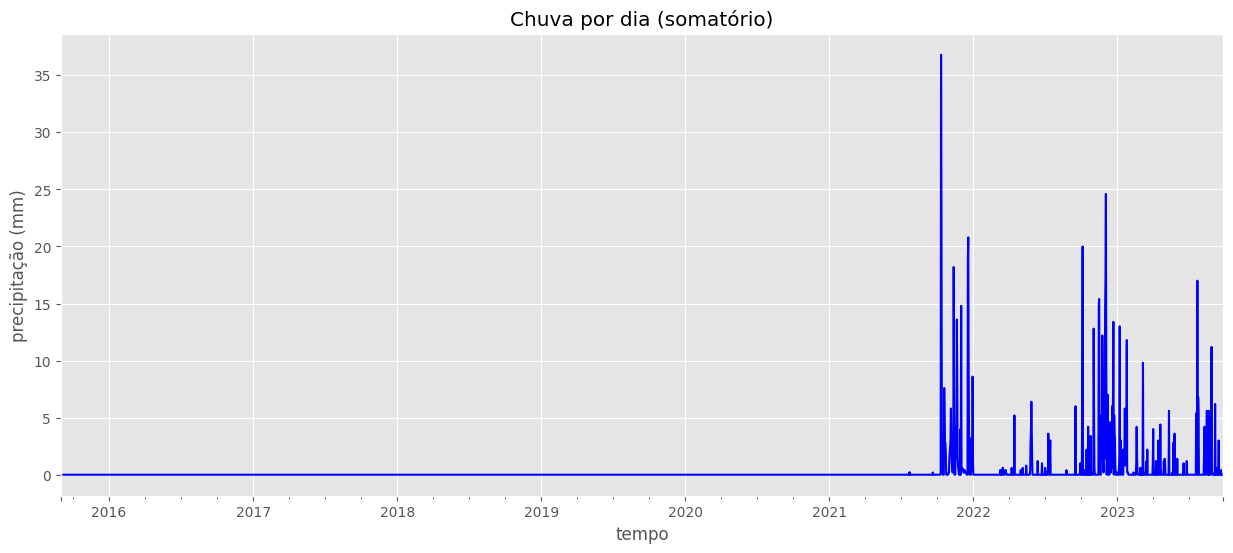

In [8]:
ds['agg_by_day'].chuva.plot(title="Chuva por dia (somatório)", color='b', xlabel='tempo', ylabel='precipitação (mm)')

<Axes: title={'center': 'Vazão por dia (média)'}, xlabel='tempo', ylabel='vazão ($m^3$/s)'>

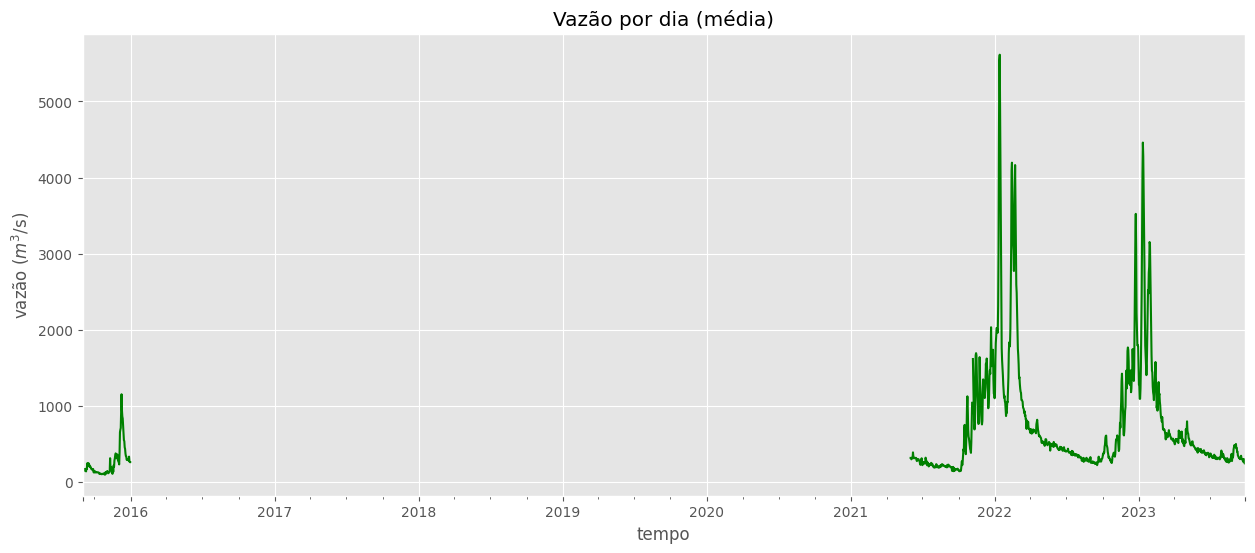

In [9]:
ds['agg_by_day'].vazao.plot(title="Vazão por dia (média)", color='g', xlabel='tempo', ylabel='vazão ($m^3$/s)')

# Pré-processamento dos dados

In [10]:
ds['agg_by_day'].dtypes

chuva    float64
vazao    float64
dtype: object

In [11]:
# Olhando se tem dados faltantes (0 ou NaN) e contando.

ds['agg_by_day'].isna().sum()

chuva       0
vazao    1979
dtype: int64

In [12]:
# Para este dataset, vale à pena mesmo pegar dados a partir de 2021. Tem um salto de anos muito longo, de 2015 para 2021.
# E como para 2015 os dados de chuva estão todos "NaN", seriam excluídos de qualquer forma mesmo.
# Contudo, deixando ".year >= 2021" apenas para compreensão da linha de raciocínio seguida por mim (Welson)

len(ds['agg_by_day'][ds['agg_by_day'].index.year >= 2021]), ds['agg_by_day'][ds['agg_by_day'].index.year >= 2021].isna().sum()

(1000,
 chuva      0
 vazao    152
 dtype: int64)

In [13]:
df_media_diaria_2021 = ds['agg_by_day'][ds['agg_by_day'].index.year >= 2021]
len(df_media_diaria_2021)

1000

In [14]:
# df_media_diaria.dropna(inplace=True)
# df_media_diaria.shape

df_media_diaria_2021.isna().sum()

chuva      0
vazao    152
dtype: int64

In [15]:
df_media_diaria_2021.describe()

,chuva,vazao
count,1000.000000,848.000000
mean,0.768800,772.181046
std,2.824231,782.626901
min,0.000000,142.390000
25%,0.000000,313.491953
50%,0.000000,478.927292
75%,0.000000,959.890964
max,36.800000,5614.181882


In [16]:
#É possível ver que existem dados de vazão NaN. Estes dados serão cortados
df_media_diaria_2021.vazao.fillna(value=df_media_diaria_2021.vazao.mean(), inplace=True)

df_media_diaria_2021.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1000 entries, 2021-01-01 to 2023-09-27
Freq: D
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   chuva   1000 non-null   float64
 1   vazao   1000 non-null   float64
dtypes: float64(2)
memory usage: 23.4 KB


# Análise exploratória dos dados

In [17]:
# Especificando a frequência como "diária"
# Isso fará surgir, eventualmente, alguma linha com valores "NaN".
df_media_diaria_2021 = df_media_diaria_2021.resample('D').first()

In [18]:
df_media_diaria_2021.describe()

,chuva,vazao
count,1000.000000,1000.000000
mean,0.768800,772.181046
std,2.824231,720.632314
min,0.000000,142.390000
25%,0.000000,326.531198
50%,0.000000,562.079635
75%,0.000000,772.181046
max,36.800000,5614.181882


<Axes: title={'center': 'Chuva'}, xlabel='Meses', ylabel='Precipitação (mm)'>

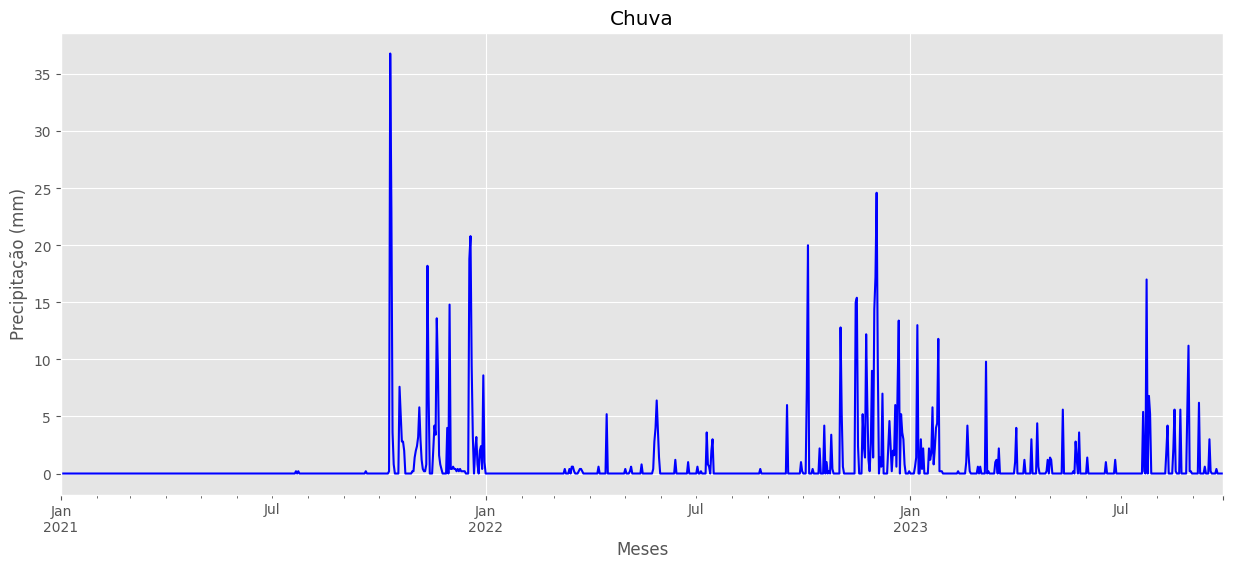

In [19]:
# Plotando a série de chuva
df_media_diaria_2021.chuva.plot(title='Chuva', color='b', xlabel='Meses', ylabel='Precipitação (mm)')

<Axes: title={'center': 'Vazão'}, xlabel='Meses', ylabel='Vazão ($m^3/s$)'>

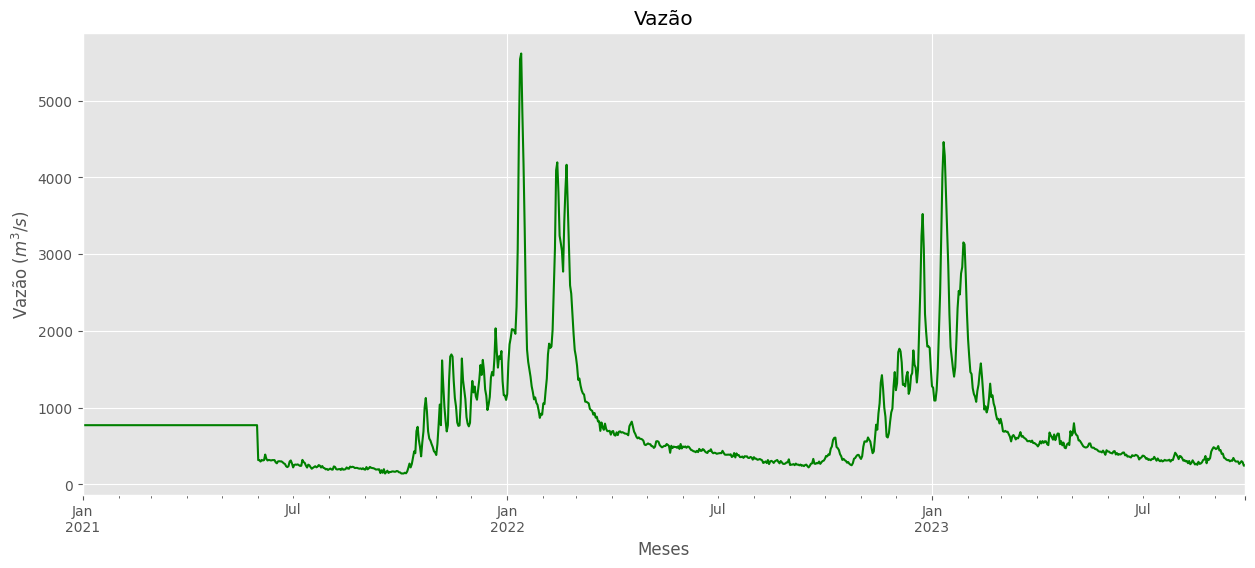

In [20]:
# Plotando a série de vazão
df_media_diaria_2021.vazao.plot(title='Vazão', color='g', xlabel='Meses', ylabel='Vazão ($m^3/s$)')

In [21]:
# Decompondo cada uma das séries analisadas
from statsmodels.tsa.seasonal import seasonal_decompose

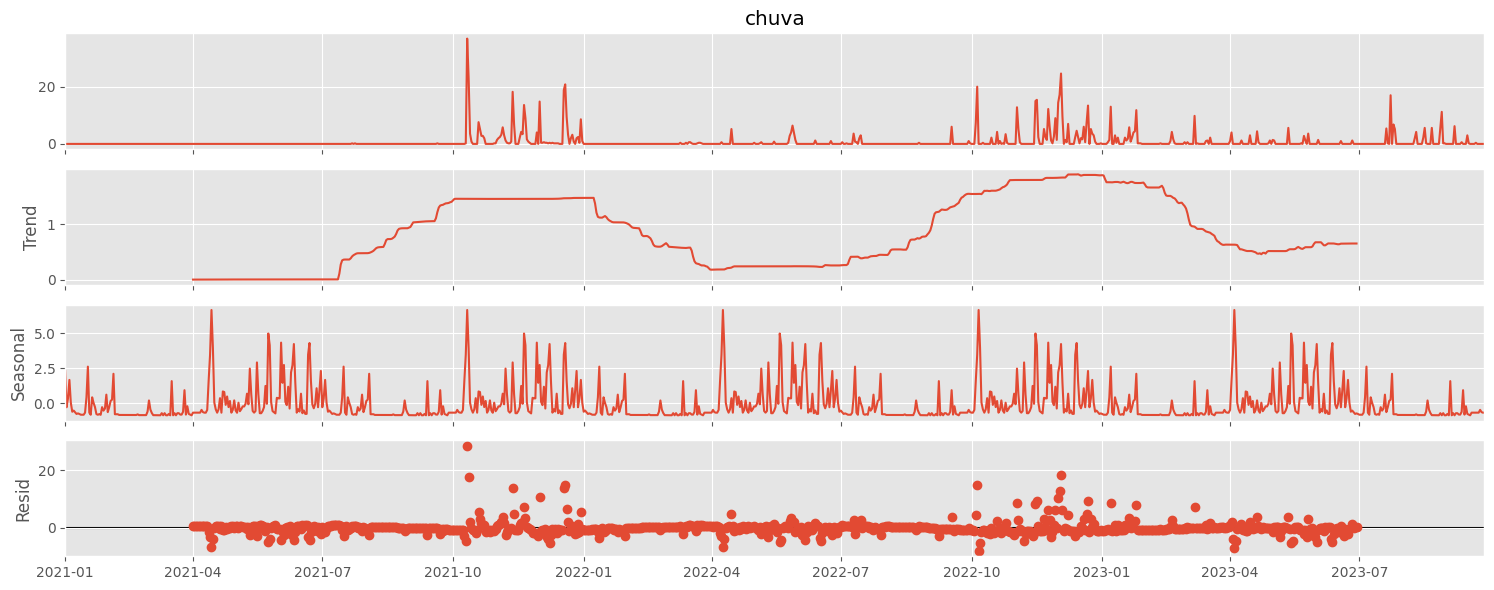

In [22]:
r_chuva = seasonal_decompose(df_media_diaria_2021.chuva, period=180, model="add")
r_chuva.plot();

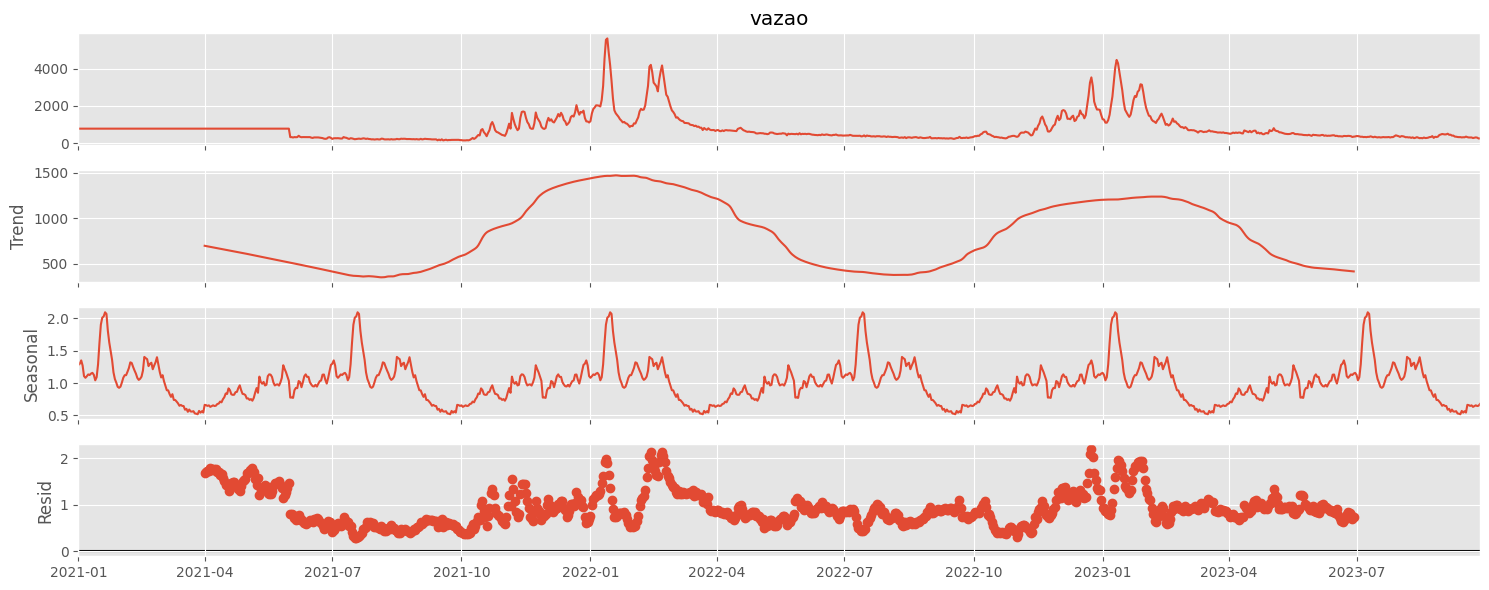

In [23]:
r_vazao = seasonal_decompose(df_media_diaria_2021.vazao, period=180, model="mult")
r_vazao.plot();

### Teste de Estacionariedade

In [24]:
from statsmodels.tsa.stattools import adfuller

In [25]:
result = adfuller(df_media_diaria_2021.vazao)
print(f'p-value: {result[1]}')

p-value: 0.02577700368952791


A série de vazões **é uma série estacionária**.

In [26]:
result = adfuller(df_media_diaria_2021.chuva)
print(f'p-value: {result[1]}')

p-value: 0.00029051329369650755


A série de chuvas é **estacionária**.

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Text(0.5, 1.0, 'ACF "vazao"')

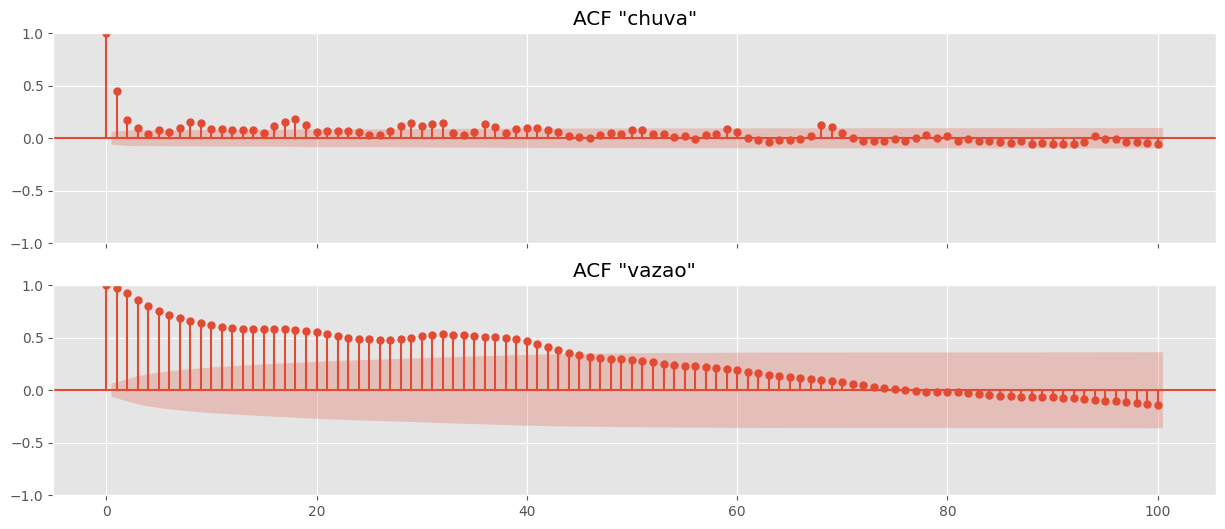

In [28]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
plot_acf(df_media_diaria_2021.chuva, ax=axs[0], lags=100, alpha=0.05)
axs[0].set_title('ACF "chuva"')
plot_acf(df_media_diaria_2021.vazao, ax=axs[1], lags=100, alpha=0.05)
axs[1].set_title('ACF "vazao"')

Text(0.5, 1.0, 'PACF "vazao"')

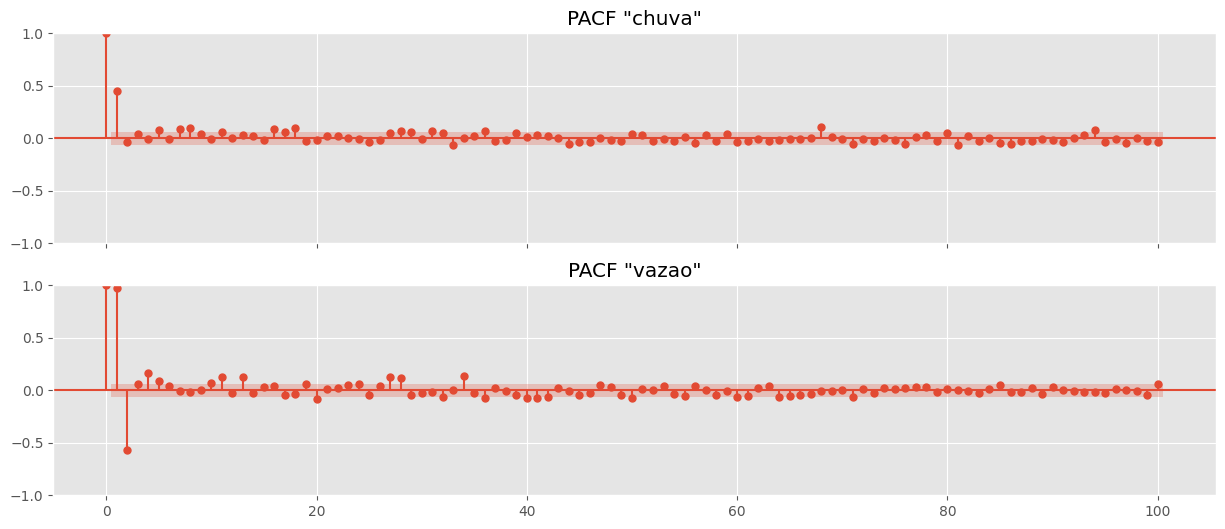

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
plot_pacf(df_media_diaria_2021.chuva, ax=axs[0], lags=100, alpha=0.05)
axs[0].set_title('PACF "chuva"')
plot_pacf(df_media_diaria_2021.vazao, ax=axs[1], lags=100, alpha=0.05)
axs[1].set_title('PACF "vazao"')

Text(0.5, 0, 'Meses')

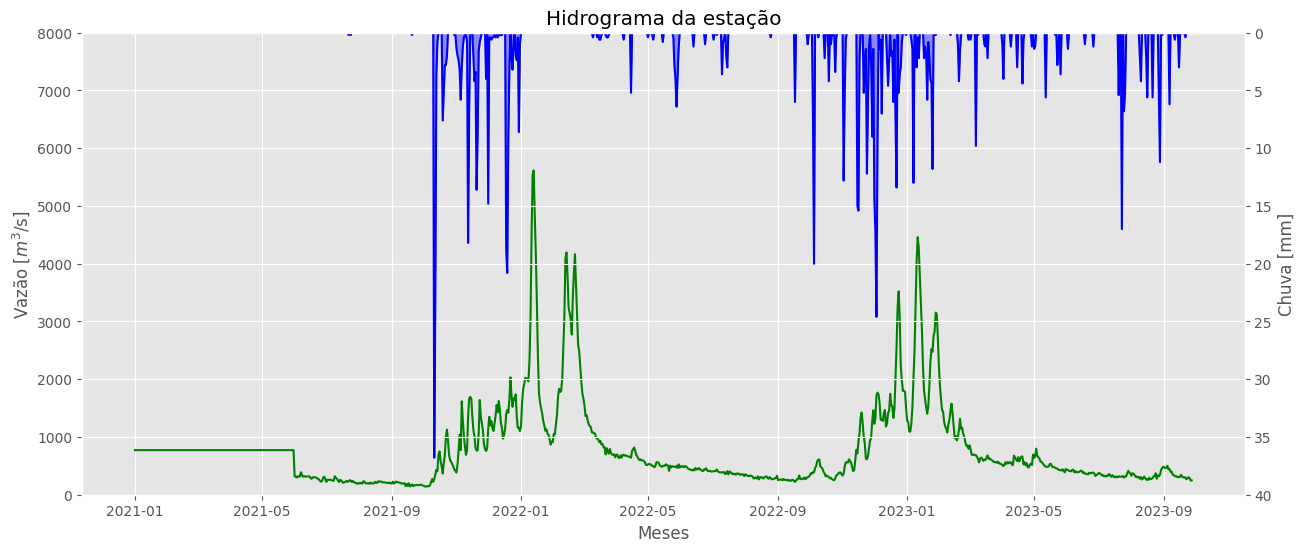

In [30]:
# Hidrograma da estação
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sns.lineplot(x=df_media_diaria_2021.index, y="chuva", data=df_media_diaria_2021, color="blue", ax=ax2)
ax2.fill_between(df_media_diaria_2021.index, 0, df_media_diaria_2021["chuva"], color='blue', alpha = 0.4)
ax2.set(ylim=(0, 40))
ax2.set_ylabel("Chuva [mm]")
ax2.invert_yaxis()

sns.lineplot(x=df_media_diaria_2021.index, y="vazao", data=df_media_diaria_2021, color="green", ax=ax1)
ax1.set(ylim=(0, 8000))
ax1.set_title('Hidrograma da estação')
ax1.set_ylabel("Vazão [$m^3$/s]")
ax1.set_xlabel("Meses")

In [31]:
# Precisa equalizar as unidades de medida. Converter m^3 para mm
# Fator de conversão de m^3 para mm^3 -> [mm^3 = m^3 x 1e+9] (1 bilhão)
# df_media_diaria_2021.vazao = df_media_diaria_2021.vazao * 1e+9
# df_media_diaria_2021

In [32]:
# LSTM_UNITS = [32, 64, 128, 256]
# BATCH_SIZE = [1, 4, 8, 16, 32]
# EPOCHS = [50, 100, 150, 200]
# ACTIVATORS = ['relu', 'tanh', 'softmax', 'sigmoid']

In [33]:
# import itertools

# i = 0
# for units, batch, epoch, activator in itertools.product(LSTM_UNITS, BATCH_SIZE, EPOCHS, ACTIVATORS):
#   i += 1
#   print(i, units, batch, epoch, activator)

# Baseline

Estabelecendo uma baseline para comparar com o modelo LSTM e NHITS empregados no trabalho

In [34]:
# _train_data = df_media_diaria_2021.copy()[df_media_diaria_2021.index < ds['valid_start_dt']][['chuva', 'vazao']]
_train_data = df_media_diaria_2021.copy()[df_media_diaria_2021.index < ds['test_start_dt']][['chuva', 'vazao']]
_valid_data = df_media_diaria_2021.copy()[(df_media_diaria_2021.index >= ds['valid_start_dt']) & (df_media_diaria_2021.index < ds['test_start_dt'])][['chuva', 'vazao']]
_test_data = df_media_diaria_2021.copy()[ds['test_start_dt']:][['chuva', 'vazao']]

In [35]:
_train_data, _test_data, _valid_data

(            chuva       vazao
 data_hora                    
 2021-01-01    0.0  772.181046
 2021-01-02    0.0  772.181046
 2021-01-03    0.0  772.181046
 2021-01-04    0.0  772.181046
 2021-01-05    0.0  772.181046
 ...           ...         ...
 2023-09-08    0.0  400.730521
 2023-09-09    0.0  347.213958
 2023-09-10    0.0  339.393021
 2023-09-11    0.6  323.573854
 2023-09-12    0.0  316.173750
 
 [985 rows x 2 columns],
             chuva       vazao
 data_hora                    
 2023-09-13    0.0  318.417340
 2023-09-14    0.0  301.008646
 2023-09-15    3.0  310.921042
 2023-09-16    0.2  307.469792
 2023-09-17    0.0  345.240313
 2023-09-18    0.0  316.320208
 2023-09-19    0.0  298.462812
 2023-09-20    0.0  298.589896
 2023-09-21    0.4  299.695104
 2023-09-22    0.0  267.824792
 2023-09-23    0.0  283.482604
 2023-09-24    0.0  303.319792
 2023-09-25    0.0  289.295000
 2023-09-26    0.0  244.050104
 2023-09-27    0.0  247.563947,
             chuva       vazao
 data_hora 

In [36]:
# Vou tabular a série temporal pegando 3 lags pra isso.
# Desta forma, considero que os "t-3" dias anteriores medidos influeciam a medição no tempo "t" e também a chuva prevista para o dia "t".
lags = 3 # quantidade de dias observados passado
targets = 1 # prever apenas vazão
# tab_data = sliding_window(df_media_diaria_2021.values, n_lags=lags, n_targets=targets)
train_data = sliding_window(_train_data.values, n_lags=lags, n_targets=targets)
valid_data = sliding_window(_valid_data.values, n_lags=lags, n_targets=targets)
test_data = sliding_window(_test_data.values, n_lags=lags, n_targets=targets)

# Alterando os nomes das colunas para ficar mais legível.
train_data.columns=['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'vazao']
valid_data.columns=['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'vazao']
test_data.columns=['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7', 'vazao']
train_data.reset_index(inplace=True, drop=True)
valid_data.reset_index(inplace=True, drop=True)
test_data.reset_index(inplace=True, drop=True)

train_data, test_data, valid_data

(     X_1         X_2  X_3         X_4  X_5         X_6  X_7       vazao
 0    0.0  772.181046  0.0  772.181046  0.0  772.181046  0.0  772.181046
 1    0.0  772.181046  0.0  772.181046  0.0  772.181046  0.0  772.181046
 2    0.0  772.181046  0.0  772.181046  0.0  772.181046  0.0  772.181046
 3    0.0  772.181046  0.0  772.181046  0.0  772.181046  0.0  772.181046
 4    0.0  772.181046  0.0  772.181046  0.0  772.181046  0.0  772.181046
 ..   ...         ...  ...         ...  ...         ...  ...         ...
 977  0.0  443.089375  6.2  446.786146  0.0  398.229062  0.0  400.730521
 978  6.2  446.786146  0.0  398.229062  0.0  400.730521  0.0  347.213958
 979  0.0  398.229062  0.0  400.730521  0.0  347.213958  0.0  339.393021
 980  0.0  400.730521  0.0  347.213958  0.0  339.393021  0.6  323.573854
 981  0.0  347.213958  0.0  339.393021  0.6  323.573854  0.0  316.173750
 
 [982 rows x 8 columns],
     X_1         X_2  X_3         X_4  X_5         X_6  X_7       vazao
 0   0.0  318.417340  0.0

In [37]:
# DataFrame de input (X) e DataFrame de output (y)
X_training = train_data[['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7']]
y_training = train_data[['vazao']]

X_validation = valid_data[['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7']]
y_validation = valid_data[['vazao']]

X_test = test_data[['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7']]
y_test = test_data[['vazao']]

# Resetando os índices e removendo a coluna de índices antiga
X_training.reset_index(drop=True, inplace=True)
y_training.reset_index(drop=True, inplace=True)
X_validation.reset_index(drop=True, inplace=True)
y_validation.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_training.shape, y_training.shape, X_test.shape, y_test.shape, X_validation.shape, y_validation.shape

((982, 7), (982, 1), (12, 7), (12, 1), (72, 7), (72, 1))

In [38]:
# Normalizando os valores pois tem valores EXTREMAMENTE distantes.
in_scaler = MinMaxScaler(feature_range=(0, 1))

X_training_scaled = in_scaler.fit_transform(X_training) # Apenas os dados de treinamento passam por fit
X_validation_scaled = in_scaler.transform(X_validation)
X_test_scaled = in_scaler.transform(X_test)

out_scaler = MinMaxScaler(feature_range=(0, 1))
y_training_scaled = out_scaler.fit_transform(y_training) # Apenas os dados de treinamento passam por fit
y_validation_scaled = out_scaler.transform(y_validation)
y_test_scaled = out_scaler.transform(y_test)

# inverse transform and print
# inversed = scaler.inverse_transform(normalized)
# print(inversed)

# pd.DataFrame(data=X_training_scaled), pd.DataFrame(data=y_training_scaled)

In [39]:
# Usando o DataFrame tab_data para plotar um heatmap

pd.DataFrame(data=in_scaler.fit_transform(train_data), columns=['chuva_4', 'vazao_3', 'chuva_3', 'vazao_2', 'chuva_2', 'vazao_1', 'chuva_1', 'vazao_y']).corr().style.background_gradient(cmap='coolwarm')

,chuva_4,vazao_3,chuva_3,vazao_2,chuva_2,vazao_1,chuva_1,vazao_y
chuva_4,1.000000,0.086305,0.448310,0.120625,0.174238,0.148754,0.095975,0.170575
vazao_3,0.086305,1.000000,0.056502,0.976144,0.040647,0.925559,0.033297,0.863442
chuva_3,0.448310,0.056502,1.000000,0.086455,0.448268,0.120773,0.174238,0.148899
vazao_2,0.120625,0.976144,0.086455,1.000000,0.056529,0.976153,0.040806,0.925588
chuva_2,0.174238,0.040647,0.448268,0.056529,1.000000,0.086478,0.448225,0.120790
vazao_1,0.148754,0.925559,0.120773,0.976153,0.086478,1.000000,0.056690,0.976163
chuva_1,0.095975,0.033297,0.174238,0.040806,0.448225,0.056690,1.000000,0.086636
vazao_y,0.170575,0.863442,0.148899,0.925588,0.120790,0.976163,0.086636,1.000000


## O modelo eXtreme Gradient Boosting

In [40]:
# from sklearn.metrics import get_scorer_names
# get_scorer_names()

###**Tree-specific hyperparameters control the construction and complexity of the decision trees:**

<u>max_depth</u>: maximum depth of a tree. Deeper trees can capture more complex patterns in the data, but may also lead to overfitting. <<range: [0,∞]>>

<u>min_child_weight</u>: minimum sum of instance weight (hessian) needed in a child. This can be used to control the complexity of the decision tree by preventing the creation of too small leaves. <<range: [0,∞]>>

<u>subsample</u>: percentage of rows used for each tree construction. Lowering this value can prevent overfitting by training on a smaller subset of the data. <<range: (0,1]>>

<u>colsample_bytree</u>: percentage of columns used for each tree construction. Lowering this value can prevent overfitting by training on a subset of the features. <<range: (0, 1]>>
<br/><br/><br/><br/>
###**Learning task-specific hyperparameters control the overall behavior of the model and the learning process:**

<u>eta (also known as learning rate)</u>: step size shrinkage used in updates to prevent overfitting. Lower values make the model more robust by taking smaller steps. <<range: [0,1]>>

<u>gamma</u>: minimum loss reduction required to make a further partition on a leaf node of the tree. Higher values increase the regularization. <<range: [0,∞]>>

<u>lambda</u>: L2 regularization term on weights. Higher values increase the regularization. <<range: [0,∞]>>

<u>alpha</u>: L1 regularization term on weights. Higher values increase the regularization. <<range: [0,∞]>>

In [41]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

params = {
    'n_estimators' : stats.randint(10, 1000),
    'max_depth' : stats.randint(1, 1000),
    'min_child_weight' : stats.uniform(0, 1000),
    'subsample' : stats.uniform(1e-5, 1),
    'colsample_bytree' : stats.uniform(1e-5, 1),
    # 'learning_rate' : stats.uniform(0.01, 1),
    # 'gamma' : stats.uniform(0, 1000),
    # 'reg_lambda' : stats.uniform(0, 1000),
    # 'alpha' : stats.uniform(0, 1000),
}

xgb_model = XGBRegressor()

cv = TimeSeriesSplit(n_splits=7)

rand_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=1000, cv=cv, scoring='neg_mean_absolute_error')
rand_search.fit(X_training_scaled, y_training_scaled)

print("Best set of hyperparameters: ", rand_search.best_params_)
print("Best score: ", rand_search.best_score_)

Best set of hyperparameters:  {'colsample_bytree': 0.9752521741904914, 'max_depth': 258, 'min_child_weight': 2.5732648093738097, 'n_estimators': 623, 'subsample': 0.8581698840682309}
Best score:  -0.03935643958554454


Curioso notar como que otimizando a estrutura e complexidade da árvore deu melhor resultado que otimizar o processo de aprendizado do modelo...

In [42]:
rand_search.score(X_training_scaled, y_training_scaled)

-0.0007426589933177501

In [43]:
m_xgb = XGBRegressor(colsample_bytree=0.997709606709281, max_depth=871, min_child_weight=1.7312411371163128, n_estimators=320, subsample=0.7794983758222706)
m_xgb.fit(X_training_scaled, y_training_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.997709606709281, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=871,
             max_leaves=None, min_child_weight=1.7312411371163128, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=320,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [44]:
vazao_pred_gb = pd.DataFrame(data=m_xgb.predict(X_test_scaled), columns=['pred'])
vazao_pred_gb['obs'] = pd.DataFrame(y_test_scaled)
vazao_pred_gb

,pred,obs
0,0.027965,0.030169
1,0.031337,0.037072
2,0.042533,0.031787
3,0.031541,0.028523
4,0.031148,0.028546
5,0.030651,0.028748
6,0.028842,0.022924
7,0.022644,0.025785
8,0.029215,0.029411
9,0.029393,0.026848


In [45]:
original_data = pd.DataFrame(data=out_scaler.inverse_transform(vazao_pred_gb), columns=['pred', 'obs'])
original_data

,pred,obs
0,295.406641,307.469792
1,313.860441,345.240313
2,375.121821,316.320208
3,314.974570,298.462812
4,312.823028,298.589896
5,310.108366,299.695104
6,300.206383,267.824792
7,266.294795,283.482604
8,302.250584,303.319792
9,303.221434,289.295000


(0.07154820977210874, 0.30499161923311047)

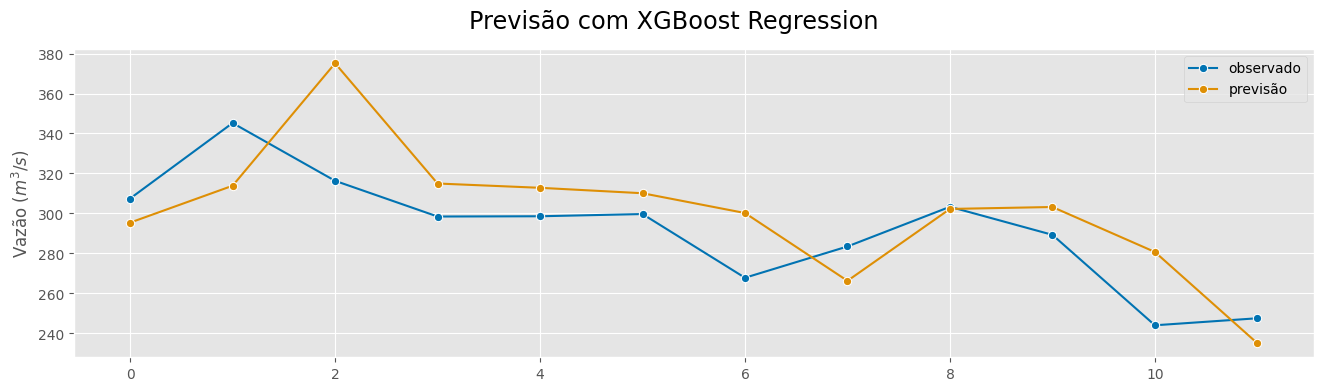

In [46]:
# inversed = scaler.inverse_transform(normalized)
# print(inversed)

plot_series(original_data['obs'], original_data['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Previsão com XGBoost Regression')

smape(original_data['obs'], original_data['pred']), mase(original_data['obs'], original_data['pred'], y_train=out_scaler.inverse_transform(y_training_scaled)) #, r2_score(original_data['obs'], original_data['pred'])

## O modelo Random Forest

In [47]:
rf = RandomForestRegressor()
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
params = {
    'bootstrap': [True, False],
    'ccp_alpha': 0.0,
    'criterion': ['gini', 'entropy', 'log_loss' 'squared_error'],
    'max_depth': [1, 10, 100, 150],
    'max_features': stats.uniform(0, 1000),
    'max_leaf_nodes': None,
    'max_samples': None,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'min_weight_fraction_leaf': 0.0,
    'n_estimators': stats.randint(10, 1000),
    'n_jobs': None,
    'oob_score': False,
    'verbose': 0,
    'warm_start': False,
    'min_child_weight' : stats.uniform(0, 1000),
    'subsample' : stats.uniform(1e-5, 1),
    'colsample_bytree' : stats.uniform(1e-5, 1),
    # 'learning_rate' : stats.uniform(0.01, 1),
    # 'gamma' : stats.uniform(0, 1000),
    # 'reg_lambda' : stats.uniform(0, 1000),
    # 'alpha' : stats.uniform(0, 1000),
}

xgb_model = XGBRegressor()

cv = TimeSeriesSplit(n_splits=7)

rand_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=1000, cv=cv, scoring='neg_mean_absolute_error')
rand_search.fit(X_training_scaled, y_training_scaled)

print("Best set of hyperparameters: ", rand_search.best_params_)
print("Best score: ", rand_search.best_score_)

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x7c22af103400>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/xgboost/core.py", line 589, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument
KeyboardInterrupt: 


## O modelo Linear Regression

In [ ]:
m_lr = LinearRegression()
m_lr.fit(X_training_scaled, y_training_scaled)

LinearRegression()

In [ ]:
pred_lr = m_lr.predict(X_validation_scaled)
vazao_pred_lr = pd.DataFrame(data=pred_lr, columns=['pred'])
vazao_pred_lr['obs'] = pd.DataFrame(y_validation_scaled)

(0.14425693879166618, 0.771706317849121)

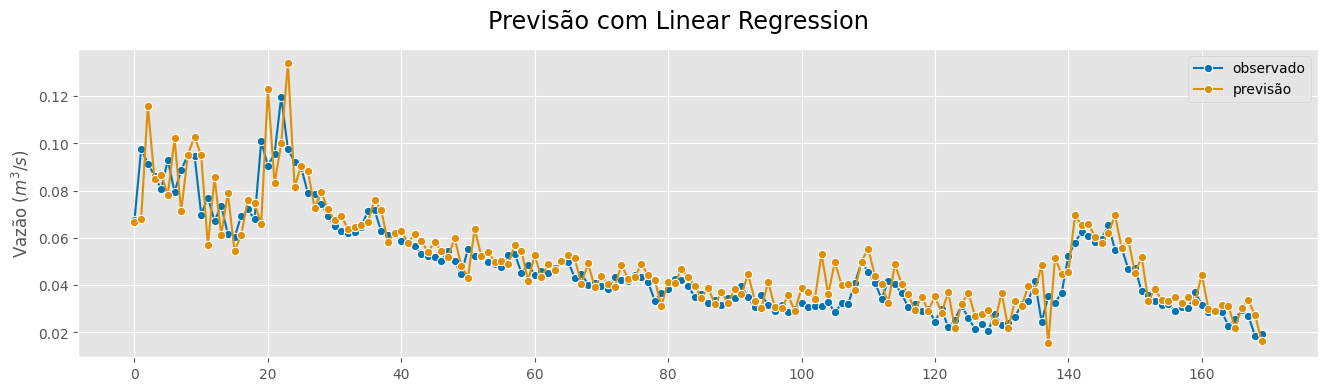

In [ ]:
plot_series(vazao_pred_lr['obs'], vazao_pred_lr['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Previsão com Linear Regression')

smape(vazao_pred_lr['obs'].values, vazao_pred_lr['pred'].values),r2_score(vazao_pred_lr['obs'].values, vazao_pred_lr['pred'].values)

# LSTM

Usando a implementação da biblioteca **KERAS**

In [ ]:
# Variável para armazenar todos os cálculos de desempenho dos modelos empregados
desempenho = {}

## Preparando os dados

In [ ]:
# X de treino
X_lstm = X_training_scaled.reshape(X_training_scaled.shape[0], X_training_scaled.shape[1], 1)
X_lstm.shape

(676, 7, 1)

In [ ]:
# y de treino
y_lstm = y_training_scaled.reshape(y_training_scaled.shape[0], y_training_scaled.shape[1], 1)
y_lstm.shape

(676, 1, 1)

In [ ]:
# X para validaçao
X_valid_lstm = X_validation_scaled.reshape(X_validation_scaled.shape[0],  X_validation_scaled.shape[1], 1)
X_valid_lstm.shape

(170, 7, 1)

In [ ]:
# y para pevisão
y_valid_lstm = y_validation_scaled.reshape(y_validation_scaled.shape[0],  y_validation_scaled.shape[1], 1)
y_valid_lstm.shape

(170, 1, 1)

## Vanilla LSTM

In [ ]:
# vanilla_lstm = Sequential()
# vanilla_lstm.add(LSTM(128, activation='relu', input_shape=(X_lstm.shape[1], 1)))
# vanilla_lstm.add(Dense(1))
# vanilla_lstm.compile(optimizer='adam', loss='mse')

vanilla_lstm = Sequential(name='vanilla_lstm')
vanilla_lstm.add(LSTM(LSTM_UNITS, activation='relu', input_shape=(T, N_FEATURES)))
vanilla_lstm.add(Dense(1))
vanilla_lstm.compile(optimizer='adam', loss='mse')
vanilla_lstm.summary()

Model: "vanilla_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67072     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 67201 (262.50 KB)
Trainable params: 67201 (262.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
vanilla_lstm.fit(train_inputs['X'],
                 train_inputs['target'],
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 validation_data=(valid_inputs['X'], valid_inputs['target']),
                 verbose=0)
vazao_pred_df = pd.DataFrame(data=vanilla_lstm.predict(test_inputs['X'], verbose=1), columns=['pred'])
vazao_pred_df['obs'] = test_inputs['target'].reshape(-1,)
vazao_pred_df

1/1 [==============================] - 0s 231ms/step


,pred,obs
0,0.035196,0.030169
1,0.032964,0.037072
2,0.039229,0.031787
3,0.032346,0.028523
4,0.028869,0.028546
5,0.028151,0.028748
6,0.028703,0.022924
7,0.024030,0.025785
8,0.026158,0.029411
9,0.028691,0.026848


{'SMAPE': 0.1255127537115735,
 'R2': 0.21927512832235008,
 'MASE': 0.2203467743772402}

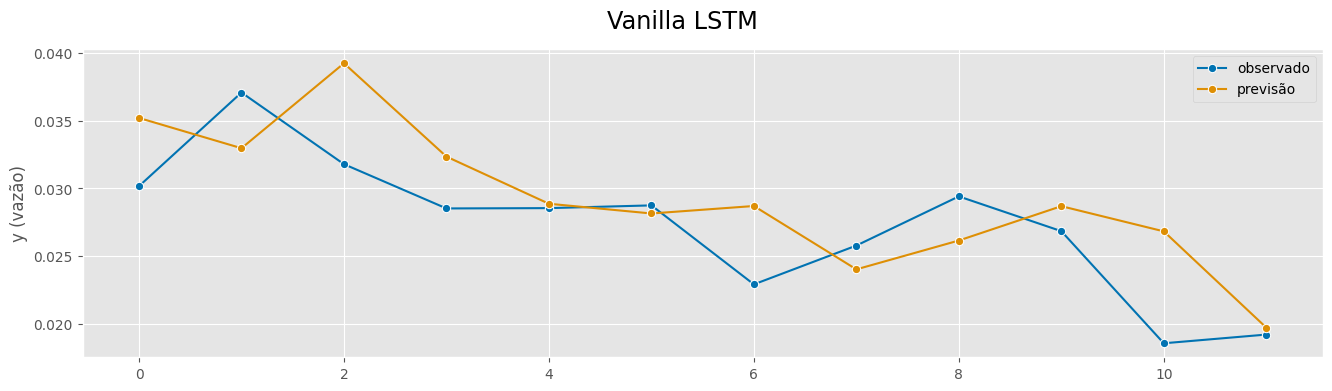

In [ ]:
plot_series(vazao_pred_df['obs'], vazao_pred_df['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='y (vazão)',
            title='Vanilla LSTM')

desempenho['VanillaLSTM'] = {'SMAPE': smape(vazao_pred_df['obs'].values, vazao_pred_df['pred'].values),
                             'R2': r2_score(vazao_pred_df['obs'].values, vazao_pred_df['pred'].values),
                             'MASE' : mase(vazao_pred_df['obs'].values, vazao_pred_df['pred'].values, y_train=train_inputs['target'].reshape(-1,))}

desempenho['VanillaLSTM']

## Bidirectional LSTM

A característica deste modelo é que ele guarda e passa informações para a célula adiante e retorna para células anteriores informações que foram ajustadas à frente, na rede. Isso potencializa o aprendizado do modelo.

In [ ]:
# bidir_lstm = Sequential()
# bidir_lstm.add(Bidirectional(LSTM(128, activation='relu', input_shape=(X_lstm.shape[1], 1))))
# bidir_lstm.add(Dense(1))
# bidir_lstm.compile(optimizer='adam', loss='mse')

seq2seq_lstm = Sequential(name='seq2seq_lstm')
seq2seq_lstm.add(LSTM(LSTM_UNITS, input_shape=(T, N_FEATURES)))
seq2seq_lstm.add(RepeatVector(HORIZON))
seq2seq_lstm.add(LSTM(LSTM_UNITS, return_sequences=True))
seq2seq_lstm.add(TimeDistributed(Dense(1)))
seq2seq_lstm.add(Flatten())
seq2seq_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
# bidir_lstm.build(input_shape=(T, N_FEATURES))
seq2seq_lstm.summary()

Model: "seq2seq_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 128)               67072     
                                                                 
 repeat_vector_20 (RepeatVe  (None, 2, 128)            0         
 ctor)                                                           
                                                                 
 lstm_49 (LSTM)              (None, 2, 128)            131584    
                                                                 
 time_distributed_18 (TimeD  (None, 2, 1)              129       
 istributed)                                                     
                                                                 
 flatten_18 (Flatten)        (None, 2)                 0         
                                                                 
Total params: 198785 (776.50 KB)
Trainable params: 198

In [ ]:
# seq2seq_lstm.fit(X_lstm, y_lstm, epochs=300, verbose=0)
# vazao_pred_df = pd.DataFrame(data=seq2seq_lstm.predict(X_valid_lstm, verbose=0), columns=['pred'])
# vazao_pred_df['obs'] = y_validation_scaled

seq2seq_lstm.fit(train_inputs['X'],
                 train_inputs['target'],
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 validation_data=(valid_inputs['X'], valid_inputs['target']),
                 verbose=0)

vazao_pred_df = pd.DataFrame(data=seq2seq_lstm.predict(test_inputs['X'], verbose=1), columns=['pred'])
vazao_pred_df['obs'] = test_inputs['target']
vazao_pred_df

1/1 [==============================] - 1s 1s/step


ValueError: ignored

In [ ]:
plot_series(vazao_pred_df['obs'], vazao_pred_df['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Seq2Seq LSTM')

desempenho['Seq2SeqLSTM'] = {'SMAPE': smape(vazao_pred_df['obs'].values, vazao_pred_df['pred'].values),
                             'R2': r2_score(vazao_pred_df['obs'].values, vazao_pred_df['pred'].values),
                             'MASE' : mase(vazao_pred_df['obs'].values, vazao_pred_df['pred'].values, y_train=train_inputs['target'])}

desempenho['Seq2SeqLSTM']

## Stacked LSTM

A ideia aqui é criar um modelo com mais de uma camada oculta, visando o aprimoramento dos resultados.

In [ ]:
stkd_lstm = Sequential()
stkd_lstm.add(LSTM(128, activation='relu', input_shape=(X_lstm.shape[1], 1)))
stkd_lstm.add(LSTM(128, activation='relu', return_sequences=True))
stkd_lstm.add(Dense(1))
stkd_lstm.compile(optimizer='adam', loss='mse')

NameError: ignored

In [ ]:
stkd_lstm.fit(X_lstm, y_lstm, epochs=300, verbose=0)
vazao_pred_df = pd.DataFrame(data=stkd_lstm.predict(X_valid_lstm, verbose=0), columns=['pred'])
vazao_pred_df['obs'] = y_validation_scaled

{'SMAPE': 0.15311852693431977,
 'R2': 0.5625002844106589,
 'RMSE': 0.013472650347636965,
 'MASE': 0.4406779705627775}

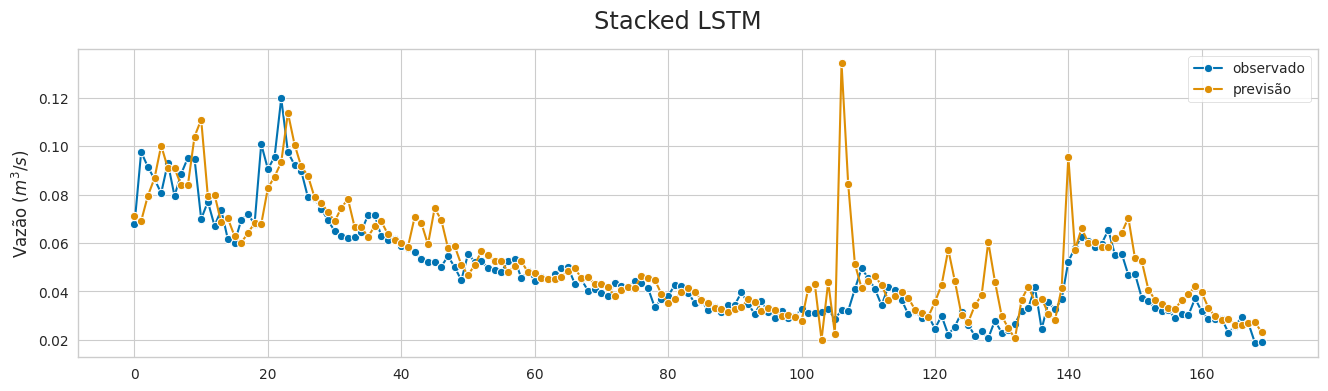

In [ ]:
plot_series(vazao_pred_df['obs'], vazao_pred_df['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Stacked LSTM')

desempenho['StackedLSTM'] = {'SMAPE': smape(vazao_pred_df['obs'], vazao_pred_df['pred'].values),
                             'R2': r2_score(vazao_pred_df['obs'], vazao_pred_df['pred'].values),
                             'RMSE' : np.sqrt(mean_squared_error(vazao_pred_df['obs'], vazao_pred_df['pred'].values)),
                             'MASE' : mase(vazao_pred_df['obs'], vazao_pred_df['pred'], y_train=y_training_scaled)}

desempenho['StackedLSTM']

## Stacked Bidirectional LSTM

In [ ]:
stkd_bi_lstm = Sequential()
stkd_bi_lstm.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True, input_shape=(X_lstm.shape[1], 1))))
stkd_bi_lstm.add(Bidirectional(LSTM(128, activation='relu')))
stkd_bi_lstm.add(Dense(1))
stkd_bi_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
stkd_bi_lstm.fit(X_lstm, y_lstm, epochs=300, verbose=0)
vazao_pred_df = pd.DataFrame(data=stkd_bi_lstm.predict(X_valid_lstm, verbose=0), columns=['pred'])
vazao_pred_df['obs'] = y_validation_scaled

{'SMAPE': 0.19407063742489353,
 'R2': 0.6679391084220996,
 'RMSE': 0.011737430023564595,
 'MASE': 0.47919165539153363}

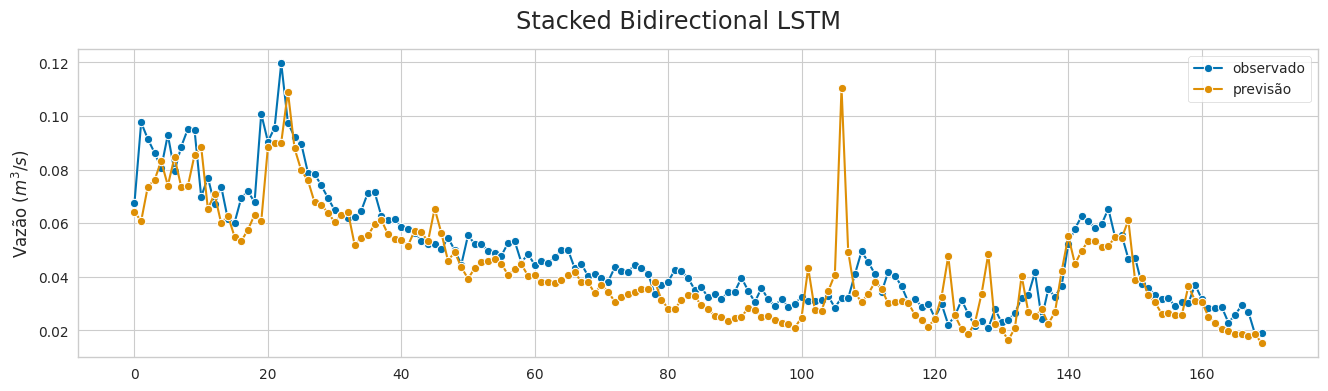

In [ ]:
plot_series(vazao_pred_df['obs'], vazao_pred_df['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Stacked Bidirectional LSTM')

desempenho['StackedBidirectionalLSTM'] = {'SMAPE': smape(vazao_pred_df['obs'], vazao_pred_df['pred'].values),
                                          'R2': r2_score(vazao_pred_df['obs'], vazao_pred_df['pred'].values),
                                          'RMSE' : np.sqrt(mean_squared_error(vazao_pred_df['obs'], vazao_pred_df['pred'].values)),
                                          'MASE' : mase(vazao_pred_df['obs'], vazao_pred_df['pred'], y_train=y_training_scaled)}

desempenho['StackedBidirectionalLSTM']

In [ ]:
# Faz o print da qualidade dos resultados de cada método empregado

# for _m1 in desempenho.items():
#   print(_m1[0] + "\n\t" + "MAPE:\t" + str(_m1[1]['MAPE'])
#                + "\n\t" + "R2:\t"   + str(_m1[1]['R2'])
#                + "\n\t" + "MSE:\t"  + str(_m1[1]['MSE']))

# desempenho_df = pd.DataFrame(data=desempenho)
# desempenho_df

### Otimização de hiperparâmetros das redes LSTM

Usando o [KerasTuner](https://keras.io/guides/keras_tuner/getting_started/)

#### Vanilla LSTM

In [ ]:
def build_vanilla(hp):
    model = Sequential()
    model.add(LSTM(# Define the hyperparameter.
                   units = hp.Int("units", min_value=16, max_value=512, step=16),
                   activation = hp.Choice('activation', ["tanh", "relu"])
                   )
    )
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
import keras_tuner

tuner = keras_tuner.RandomSearch(
    hypermodel=build_vanilla,
    executions_per_trial=2,
    objective='val_loss',
    max_trials=10)

tuner.search(X_lstm, y_lstm, epochs=300)

best_model = tuner.get_best_models()[0]

Reloading Tuner from ./untitled_project/tuner0.json

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
480               |240               |units
relu              |tanh              |activation

Epoch 1/300
22/22 [==============================] - 3s 66ms/step - loss: 0.0163
Epoch 2/300
22/22 [==============================] - 1s 65ms/step - loss: 0.0077
Epoch 3/300
22/22 [==============================] - 2s 96ms/step - loss: 0.0057
Epoch 4/300
22/22 [==============================] - 2s 72ms/step - loss: 0.0052
Epoch 5/300
22/22 [==============================] - 2s 101ms/step - loss: 0.0048
Epoch 6/300
22/22 [==============================] - 2s 86ms/step - loss: 0.0046
Epoch 7/300
22/22 [==============================] - 1s 67ms/step - loss: 0.0043
Epoch 8/300
22/22 [==============================] - 1s 68ms/step - loss: 0.0042
Epoch 9/300
22/22 [==============================] - 1s 60ms/step - loss: 0.0040
Epoch 10/300
22/22 [========================

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 264, in _run_and_update_trial
    tuner_utils.convert_to_metrics_dict(
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in convert_to_metrics_dict
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner_utils.py", line 132, in <listcomp>
    [convert_to_metrics_dict(elem, objective) for elem in results]
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner_utils.py", line 145, in convert_to_metrics_dict
    best_value, _ = _get_best_value_and_best_epoch_from_history(
  File "/usr/local/lib/python3.10/dist-packages/kera

RuntimeError: ignored

In [ ]:
best_model.build(input_shape=(X_lstm.shape[0], X_lstm.shape[1], 1))
best_model.summary()

In [ ]:
tuner.results_summary()

In [ ]:
best_hps = tuner.get_best_hyperparameters(5)
m_opt = build_vanilla(best_hps[0])
m_opt.fit(x=X_lstm, y=y_lstm, epochs=100)

In [ ]:
tuner.results_summary()

In [ ]:
vazao_pred_df = pd.DataFrame(data=m_opt.predict(X_valid_lstm, verbose=0), columns=['pred'])
vazao_pred_df['obs'] = y_validation_scaled

In [ ]:
plot_series(vazao_pred_df['obs'], vazao_pred_df['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Vanilla Opt LSTM')

desempenho['VanillaOptLSTM'] = {'SMAPE': smape(vazao_pred_df['obs'], vazao_pred_df['pred'].values),
                                'R2': r2_score(vazao_pred_df['obs'], vazao_pred_df['pred'].values),
                                'RMSE' : np.sqrt(mean_squared_error(vazao_pred_df['obs'], vazao_pred_df['pred'].values)),
                                'MASE' : mase(vazao_pred_df['obs'], vazao_pred_df['pred'], y_train=y_training_scaled)}

desempenho['VanillaOptLSTM']

In [ ]:
# # Executando os modelos em lote

# # Variável que criará a chave
# k = ''

# # Preferi separar o resultado por cada tipo de rede para me facilitar depois visualizar os resultados
# pred_van, pred_bidir, pred_stkd, pred_stkd_bi = pd.DataFrame(), pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

# # Quantidade de execuções dos modelos avaliados
# tot_runs = 7

# for i in range(0, tot_runs):
#   k = 'van_run_' + str(i+1)
#   vanilla_lstm.fit(X_lstm, y_lstm, epochs=300, verbose=0)
#   pred_van[k] = pd.DataFrame(data=vanilla_lstm.predict(X_valid_lstm, verbose=0))
#   desempenho[k] = {'SMAPE': smape(y_validation_scaled, pred_van[k].values),
#                    'R2': r2_score(y_validation_scaled, pred_van[k].values),
#                    'RMSE' : np.sqrt(mean_squared_error(y_validation_scaled, pred_van[k].values)),
#                    'MASE' : mase(y_validation_scaled, pred_van[k], y_train=y_training_scaled)}

#   k = 'bidir_run_' + str(i+1)
#   bidir_lstm.fit(X_lstm, y_lstm, epochs=300, verbose=0)
#   pred_bidir[k] = pd.DataFrame(data=bidir_lstm.predict(X_valid_lstm, verbose=0))
#   desempenho[k] = {'SMAPE': smape(y_validation_scaled, pred_bidir[k]),
#                    'R2': r2_score(y_validation_scaled, pred_bidir[k]),
#                    'RMSE' : np.sqrt(mean_squared_error(y_validation_scaled, pred_bidir[k])),
#                    'MASE' : mase(y_validation_scaled, pred_bidir[k], y_train=y_training_scaled)}

#   k = 'stkd_run_' + str(i+1)
#   stkd_lstm.fit(X_lstm, y_lstm, epochs=300, verbose=0)
#   pred_stkd[k] = pd.DataFrame(data=stkd_lstm.predict(X_valid_lstm, verbose=0))
#   desempenho[k] = {'SMAPE': smape(y_validation_scaled, pred_stkd[k]),
#                    'R2': r2_score(y_validation_scaled, pred_stkd[k]),
#                    'RMSE' : np.sqrt(mean_squared_error(y_validation_scaled, pred_stkd[k])),
#                    'MASE' : mase(y_validation_scaled, pred_stkd[k], y_train=y_training_scaled)}

#   k = 'stkd_bi_run_' + str(i+1)
#   stkd_bi_lstm.fit(X_lstm, y_lstm, epochs=300, verbose=0)
#   pred_stkd_bi[k] = pd.DataFrame(data=stkd_bi_lstm.predict(X_valid_lstm, verbose=0))
#   desempenho[k] = {'SMAPE': smape(y_validation_scaled, pred_stkd_bi[k]),
#                    'R2': r2_score(y_validation_scaled, pred_stkd_bi[k]),
#                    'RMSE' : np.sqrt(mean_squared_error(y_validation_scaled, pred_stkd_bi[k])),
#                    'MASE' : mase(y_validation_scaled, pred_stkd_bi[k], y_train=y_training_scaled)}

KeyboardInterrupt: ignored

In [ ]:
# Filtrar as colunas do dataframe de desempenho pelo modelo rodado

# Analisando as execuções do modelo Vanilla LSTM
cols = [str('van_run_%i' % (i+1)) for i in range(0, tot_runs)]

desempenho_df = pd.DataFrame(data=desempenho)
desempenho_df[cols].T.describe()

In [ ]:
desempenho_df[cols].T.plot(title='Vanilla LSTM')

In [ ]:
# Analisando as execuções do modelo Bidirectional LSTM
cols = [str('bidir_run_%i' % (i+1)) for i in range(0, tot_runs)]

desempenho_df = pd.DataFrame(data=desempenho)
desempenho_df[cols].T.describe()

In [ ]:
desempenho_df[cols].T.plot(title='Bidirectional LSTM')

In [ ]:
# Analisando as execuções do modelo Stacked LSTM
cols = [str('stkd_run_%i' % (i+1)) for i in range(0, tot_runs)]

desempenho_df = pd.DataFrame(data=desempenho)
desempenho_df[cols].T.describe()

In [ ]:
desempenho_df[cols].T.plot(title='Stacked LSTM')

In [ ]:
# Analisando as execuções do modelo Stacked Bidirectional LSTM
cols = [str('stkd_bi_run_%i' % (i+1)) for i in range(0, tot_runs)]

desempenho_df = pd.DataFrame(data=desempenho)
desempenho_df[cols].T.describe()

In [ ]:
desempenho_df[cols].T.plot(title='Stacked Bidirectional LSTM')

# NeuralForecast

The `core.NeuralForecast` class contains shared, `fit`, `predict` and other methods that take as inputs pandas DataFrames with columns `['unique_id', 'ds', 'y']`, where `unique_id` identifies individual time series from the dataset, `ds` is the date, and `y` is the target variable.

In this example dataset consists of a set of a single series, but you can easily fit your model to larger datasets in long format.

In [ ]:
# Y_df = AirPassengersDF # Defined in neuralforecast.utils
# Y_df

DataFrames must include all `['unique_id', 'ds', 'y']` columns.

**Make sure `y` column does not have missing or non-numeric values.**

In [ ]:
df = df_media_diaria_2021.copy()

# training_size = round(len(df) * 0.8) # 80% de treinamento / 20% de validação
fch = 7 # Forecast Horizon // Últimos X dias
training_size = len(df) - fch

df['ds'] = pd.to_datetime(df.index.values)
df['unique_id'] = 1.0
df['y'] = df.vazao
df.drop('vazao', axis=1, inplace=True)
df.reset_index(drop=True, inplace=True) # retira a data_hora como índice do DataFrame.

# df
# df.plot('ds', ['chuva', 'y'], xlabel='Meses', ylabel='y', label=['chuva', 'vazão'], color=['b', 'g'])
# plt.show()

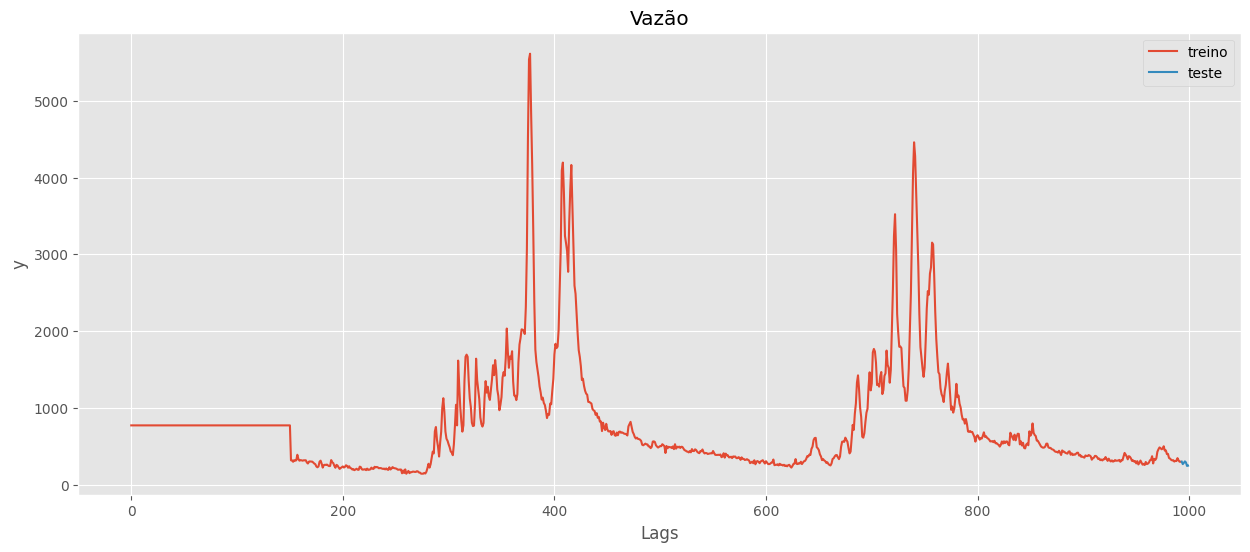

In [ ]:
df_train  = df[:training_size]
df_test = df[training_size:]
# df_train, df_test

df_train['y'].plot(label='treino')
df_test['y'].plot(label='teste')
plt.title('Vazão')
plt.xlabel('Lags')
plt.ylabel('y')
plt.legend()
plt.show()

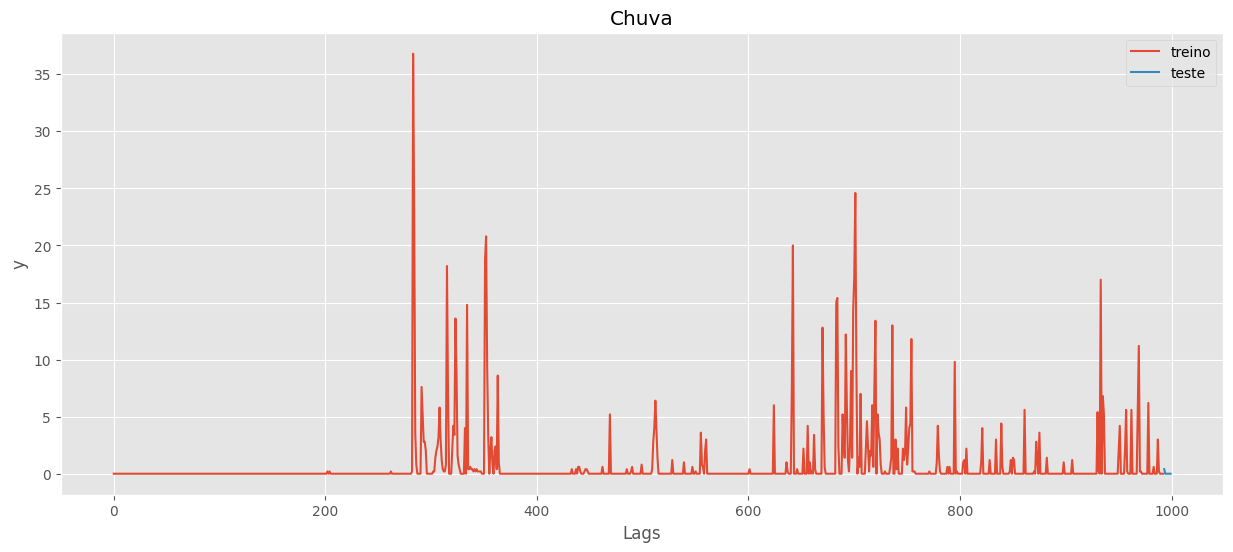

In [ ]:
df_train['chuva'].plot(label='treino')
df_test['chuva'].plot(label='teste')
plt.title('Chuva')
plt.xlabel('Lags')
plt.ylabel('y')
plt.legend()
plt.show()

In [ ]:
# df_test

## 3. Model Training

### Fit the models

Using the `NeuralForecast.fit` method you can train a set of models to your dataset. You can define the forecasting `horizon` (12 in this example), and modify the hyperparameters of the model. For example, for the `LSTM` we changed the default hidden size for both encoder and decoders.

In [ ]:
from neuralforecast.losses.pytorch import DistributionLoss

# Try different hyperparmeters to improve accuracy.
models = [
          nfLSTM(h=fch,                      # Forecast horizon // X dias
               max_steps=300,                # Number of steps to train
               loss=DistributionLoss(distribution='Normal', level=[80, 90]), # Usando a função de perda do DeepAR (famosa)
               #scaler_type='robust',        # Type of scaler to normalize data
               futr_exog_list=['chuva'],     # Variáveis adicionais que comporão o modelo
               encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               #encoder_n_layers=1,
               decoder_hidden_size=64,       # Defines the number of hidden units of each layer of the MLP decoder
               context_size=7)               # usa os X dias anteriores para prever adiante.
               #decoder_layers=1)

      #     NHITS(h=fch,                       # Forecast horizon
      #           input_size=2 * len(df_test), # Length of input sequence
      #           max_steps=300,               # Number of steps to train
      #           n_freq_downsample=[2, 1, 1]) # Downsampling factors for each stack output

          #AutoRNN(h=horizon,
          #        config=dict(max_steps=2, val_check_steps=1, input_size=-1, encoder_hidden_size=8),
          #        num_samples=1, cpus=1),
          ]
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=df_train)

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# Precisa extrair do conjunto de teste os dados das variáveis em 'futr_exog_list' e usar apenas elas pra fazer predict
chuvas_futuras = df_test[['unique_id', 'ds', 'chuva']]
chuvas_futuras

,unique_id,ds,chuva
993,1.0,2023-09-21,0.4
994,1.0,2023-09-22,0.0
995,1.0,2023-09-23,0.0
996,1.0,2023-09-24,0.0
997,1.0,2023-09-25,0.0
998,1.0,2023-09-26,0.0
999,1.0,2023-09-27,0.0


:::{.callout-tip}
The performance of Deep Learning models can be very sensitive to the choice of hyperparameters. Tuning the correct hyperparameters is an important step to obtain the best forecasts. The `Auto` version of these models, `AutoLSTM` and `AutoNHITS`, already perform hyperparameter selection automatically.
:::

### Predict using the fitted models

Using the `NeuralForecast.predict` method you can obtain the `h` forecasts after the training data `Y_df`.

In [ ]:
df_pred = nf.predict(futr_df=chuvas_futuras)
df_pred.reset_index(drop=True, inplace=True)
df_pred

Predicting: |          | 0/? [00:00<?, ?it/s]

,ds,LSTM,LSTM-median,LSTM-lo-90,LSTM-lo-80,LSTM-hi-80,LSTM-hi-90
0,2023-09-21,311.397339,312.322510,226.144608,247.809143,372.570038,389.463257
1,2023-09-22,317.365448,317.021545,240.371002,258.701904,376.527405,391.169525
2,2023-09-23,311.392029,311.661713,231.232895,249.794189,375.601379,389.448059
3,2023-09-24,308.264313,308.237579,223.972610,243.024307,371.897400,389.394928
4,2023-09-25,306.025330,306.329742,224.607803,245.387268,366.898773,382.969299
5,2023-09-26,305.781708,304.199707,227.217834,240.656158,367.770203,382.034546
6,2023-09-27,301.258118,301.261841,221.579132,240.483063,364.280609,377.744934


The `NeuralForecast.predict` method returns a DataFrame with the forecasts for each `unique_id`, `ds`, and model.

In [ ]:
df_pred['y'] = df_test['y'].values
df_pred

,ds,LSTM,LSTM-median,LSTM-lo-90,LSTM-lo-80,LSTM-hi-80,LSTM-hi-90,y
0,2023-09-21,311.397339,312.322510,226.144608,247.809143,372.570038,389.463257,299.695104
1,2023-09-22,317.365448,317.021545,240.371002,258.701904,376.527405,391.169525,267.824792
2,2023-09-23,311.392029,311.661713,231.232895,249.794189,375.601379,389.448059,283.482604
3,2023-09-24,308.264313,308.237579,223.972610,243.024307,371.897400,389.394928,303.319792
4,2023-09-25,306.025330,306.329742,224.607803,245.387268,366.898773,382.969299,289.295000
5,2023-09-26,305.781708,304.199707,227.217834,240.656158,367.770203,382.034546,244.050104
6,2023-09-27,301.258118,301.261841,221.579132,240.483063,364.280609,377.744934,247.563947


0.11343436811202826

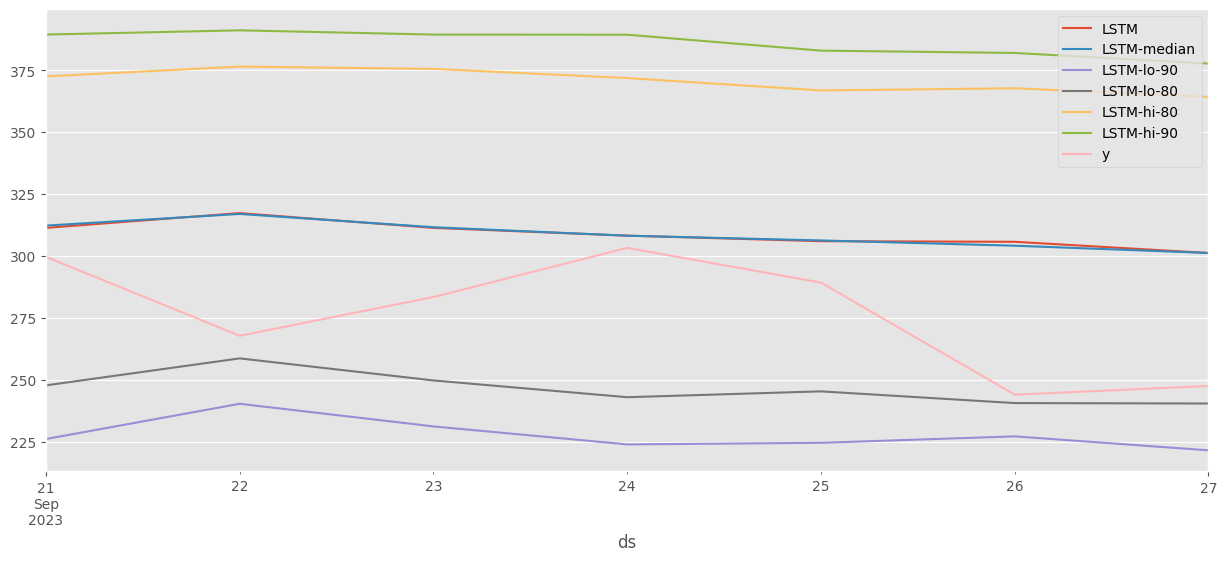

In [ ]:
df_pred.plot('ds', ['LSTM', 'LSTM-median', 'LSTM-lo-90', 'LSTM-lo-80', 'LSTM-hi-80', 'LSTM-hi-90', 'y'])
smape(df_pred['y'], df_pred['LSTM'])

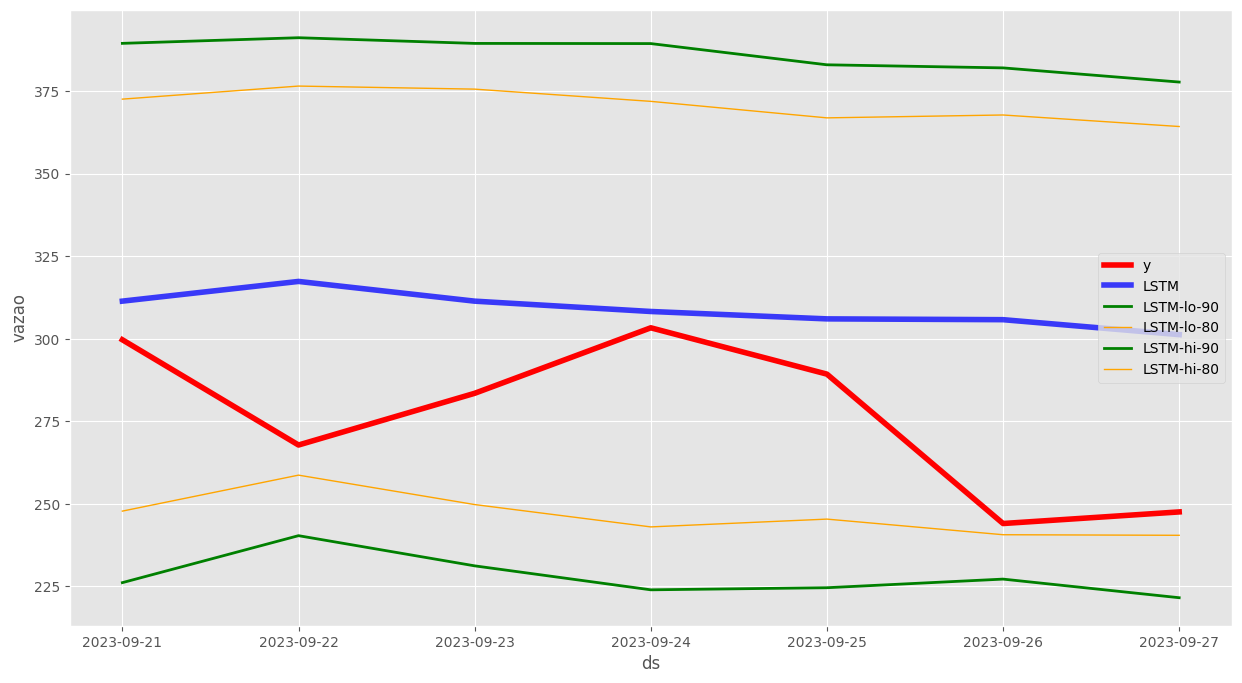

In [ ]:
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
ax.plot(df_pred['ds'], df_pred['y'], label='y', color='red', linewidth=4.0)
ax.plot(df_pred['ds'], df_pred['LSTM'], label='LSTM', color='blue', linewidth=4.0, alpha=0.75)
# ax.plot(df_pred['ds'], df_pred['LSTM-median'], label='LSTM-median', color='black', linewidth=3.0, alpha=0.5)
ax.plot(df_pred['ds'], df_pred['LSTM-lo-90'], label='LSTM-lo-90', color='green', linewidth=2.0)
ax.plot(df_pred['ds'], df_pred['LSTM-lo-80'], label='LSTM-lo-80', color='orange', linewidth=1.0)
ax.plot(df_pred['ds'], df_pred['LSTM-hi-90'], label='LSTM-hi-90', color='green', linewidth=2.0)
ax.plot(df_pred['ds'], df_pred['LSTM-hi-80'], label='LSTM-hi-80', color='orange', linewidth=1.0)
plt.xlabel('ds', fontsize=12)
plt.ylabel('vazao', fontsize=12)
plt.legend(loc='best')
plt.show()

In [ ]:
# Testando o AutoLSTM para detecção dos melhores parâmetros

models_auto = [AutoLSTM(h=fch,
                        # loss=MAE(),
                        num_samples=10)]

m_auto = NeuralForecast(models=models_auto, freq='D')

In [ ]:
%%capture
m_auto.fit(df=df_train, val_size=7)

2023-12-19 03:42:59,635	INFO tune.py:595 -- [output] This will use the new output engine with verbosity 0. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
INFO:lightning_fabric.utilities.seed:Seed set to 9


In [ ]:
results_df = m_auto.models[0].results.get_dataframe().sort_values('loss')
results_df

,loss,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,time_this_iter_s,time_total_s,pid,...,config/decoder_hidden_size,config/learning_rate,config/max_steps,config/batch_size,config/loss,config/random_seed,config/input_size,config/inference_input_size,config/valid_loss,logdir
4,1.477597e+10,1702957721,None,False,10,94fa9_00004,2023-12-19_03-48-41,0.698304,11.360653,39711,...,64,0.000131,1000,16,MAE(),9,48,-3,MAE(),94fa9_00004
6,1.933541e+10,1702957780,None,False,10,94fa9_00006,2023-12-19_03-49-40,2.173596,22.960738,39711,...,64,0.000113,1000,16,MAE(),16,-3,-3,MAE(),94fa9_00006
9,1.983288e+10,1702958068,None,False,10,94fa9_00009,2023-12-19_03-54-28,1.258313,13.045560,39711,...,512,0.005665,1000,32,MAE(),8,192,-3,MAE(),94fa9_00009
0,2.040348e+10,1702957416,None,False,10,94fa9_00000,2023-12-19_03-43-36,2.932802,30.384348,39711,...,512,0.000242,1000,32,MAE(),1,-3,-3,MAE(),94fa9_00000
7,2.069796e+10,1702957792,None,False,10,94fa9_00007,2023-12-19_03-49-52,1.053965,12.023057,39711,...,512,0.000464,1000,16,MAE(),10,192,-3,MAE(),94fa9_00007
1,2.286073e+10,1702957420,None,False,5,94fa9_00001,2023-12-19_03-43-40,0.605378,3.431603,39711,...,64,0.001550,500,16,MAE(),6,48,-3,MAE(),94fa9_00001
8,3.166860e+10,1702958055,None,False,10,94fa9_00008,2023-12-19_03-54-15,27.384330,262.793402,39711,...,64,0.003753,1000,32,MAE(),7,-3,-3,MAE(),94fa9_00008
2,3.485226e+10,1702957423,None,False,5,94fa9_00002,2023-12-19_03-43-43,0.608820,2.859146,39711,...,64,0.000121,500,16,MAE(),10,12,-3,MAE(),94fa9_00002
3,1.885765e+11,1702957709,None,False,10,94fa9_00003,2023-12-19_03-48-29,26.895589,286.578812,39711,...,256,0.025248,1000,32,MAE(),2,-3,-3,MAE(),94fa9_00003
5,4.538370e+11,1702957757,None,False,5,94fa9_00005,2023-12-19_03-49-17,7.551277,36.522996,39711,...,128,0.003976,500,16,MAE(),18,192,-3,MAE(),94fa9_00005


In [ ]:
auto_pred = m_auto.predict()
auto_pred = auto_pred.reset_index()
auto_pred['y'] = df_test['y'].values

Predicting: |          | 0/? [00:00<?, ?it/s]

In [ ]:
auto_pred

,unique_id,ds,AutoLSTM,y
0,1.0,2023-09-25,2.859445e+11,2.892950e+11
1,1.0,2023-09-26,2.869142e+11,2.440501e+11
2,1.0,2023-09-27,2.843756e+11,2.475639e+11


0.10383727754614314

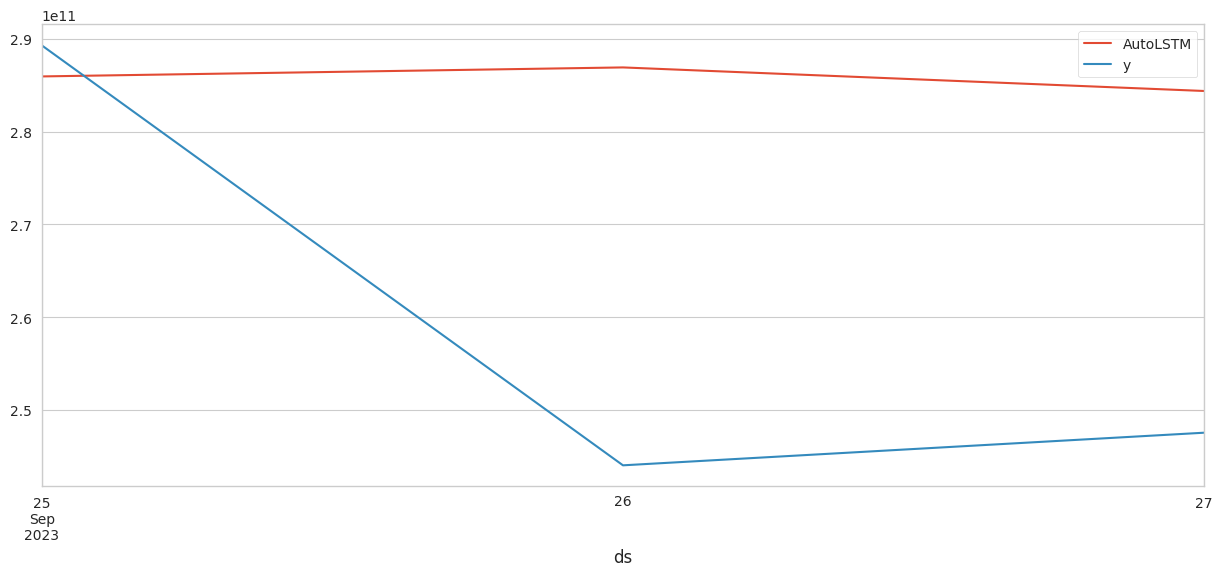

In [ ]:
auto_pred.plot('ds', ['AutoLSTM', 'y'])
smape(auto_pred['y'], auto_pred['AutoLSTM'])

In [ ]:
best_config = m_auto.models[0].results.get_best_result().metrics['config']
best_config

{'h': 3,
 'encoder_hidden_size': 50,
 'encoder_n_layers': 2,
 'context_size': 5,
 'decoder_hidden_size': 64,
 'learning_rate': 0.00013096774493777635,
 'max_steps': 1000,
 'batch_size': 16,
 'loss': MAE(),
 'random_seed': 9,
 'input_size': 48,
 'inference_input_size': -3,
 'valid_loss': MAE()}

In [ ]:
models = [
    nfLSTM(scaler_type='robust',
           futr_exog_list=['chuva'], # Variáveis adicionais que comporão o modelo
           **best_config)
]

m_opt = NeuralForecast(models=models, freq='D')
m_opt.fit(df=df_train)

INFO:lightning_fabric.utilities.seed:Seed set to 9


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
pred_opt = m_opt.predict(futr_df=chuvas_futuras)

# Só precisa executar isso uma vez
pred_opt = pred_opt.reset_index()

# Juntando os valores preditos com os valores observados
pred_opt['y'] = df_test['y'].values

Predicting: |          | 0/? [00:00<?, ?it/s]

0.09485665974989888

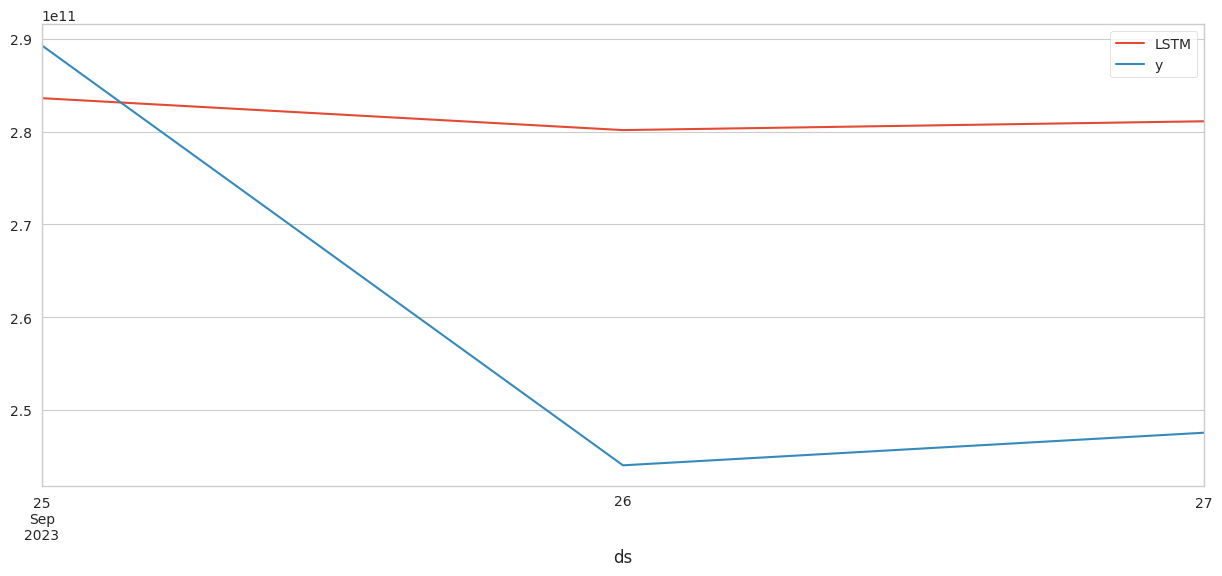

In [ ]:
pred_opt.plot('ds', ['LSTM', 'y'])
smape(pred_opt['y'], pred_opt['LSTM'])

## 4. Plot Predictions

Finally, we plot the forecasts of both models againts the real values.

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize = (20, 7))
# plot_df = pd.DataFrame(data=pred_opt).set_index('ds')
# plot_df[['y',
#          'LSTM',
        #  'NHITS',
        #  'AutoRNN',
        #  ]].plot(ax=ax, linewidth=2)

#ax.set_title('AirPassengers Forecast', fontsize=22)
#ax.set_ylabel('Monthly Passengers', fontsize=20)
#ax.set_xlabel('Timestamp [t]', fontsize=20)
#ax.legend(prop={'size': 15})
#ax.grid()

:::{.callout-tip}
For this guide we are using a simple `LSTM` model. More recent models, such as `RNN`, `GRU`, and `DilatedRNN` achieve better accuracy than `LSTM` in most settings. The full list of available models is available [here](https://nixtla.github.io/neuralforecast/models.html).
:::

In [ ]:
# fig, ax = plt.subplots(1, 1, figsize = (20, 7))

# Y_hat_df.index=Y_df_test.index
# Y_hat_df[['y',
#          'LSTM',
#          'NHITS',
        # 'AutoRNN',
        #  ]].plot(ax=ax)

## References
- [Boris N. Oreshkin, Dmitri Carpov, Nicolas Chapados, Yoshua Bengio (2020). "N-BEATS: Neural basis expansion analysis for interpretable time series forecasting". International Conference on Learning Representations.](https://arxiv.org/abs/1905.10437)<br>
- [Cristian Challu, Kin G. Olivares, Boris N. Oreshkin, Federico Garza, Max Mergenthaler-Canseco, Artur Dubrawski (2021). NHITS: Neural Hierarchical Interpolation for Time Series Forecasting. Accepted at AAAI 2023.](https://arxiv.org/abs/2201.12886)